# Итоговый проект Иванова Юрия Викторовича

# Импорты

In [163]:
!pip install phik --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import pickle
from matplotlib import rcParams
import phik
from phik import resources, report 
from phik.report import plot_correlation_matrix 
import sklearn 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer 
from sklearn import metrics 
from sklearn.multioutput import MultiOutputRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold 
from sklearn.dummy import DummyRegressor 
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scipy import stats 
from sklearn.svm import SVR 
from tensorflow import keras 

# Загрузка датасета

In [164]:
df = pd.read_csv("Downloads/ebw_data.csv", sep=';')

# Разведочный анализ и визуализация данных 

In [165]:
df.sample(5)

,IW,IF,VW,FP,Depth,Width
4,45,140,4.5,80,1.76,2.48
56,44,146,9.0,60,1.20,1.76
30,47,139,4.5,80,1.40,2.48
21,47,141,12.0,80,1.08,1.68
26,47,134,10.0,110,0.92,1.86


In [166]:
#Посмотрим размерность нашего датасета
df.shape

(72, 6)

In [167]:
#Посмотрим информацию о фрейме данных.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [168]:
# Проверим набор данные на пропуски
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

### Датасет состоит из 72 строк, 6 столбцов, содержит переменные типа float64 и int64. Набор данных качественных характеристик или категориальных признаков не имеет.Пропусков не имеется. Ни одна из записей не является NaN, очистка не требуется. 

In [169]:
#Проверим датасет на дубликаты
df.duplicated().sum()
print('Найдено', len(df) - len(df.drop_duplicates()), 'дубликатов') 

Найдено 7 дубликатов


<Axes: ylabel='Density'>

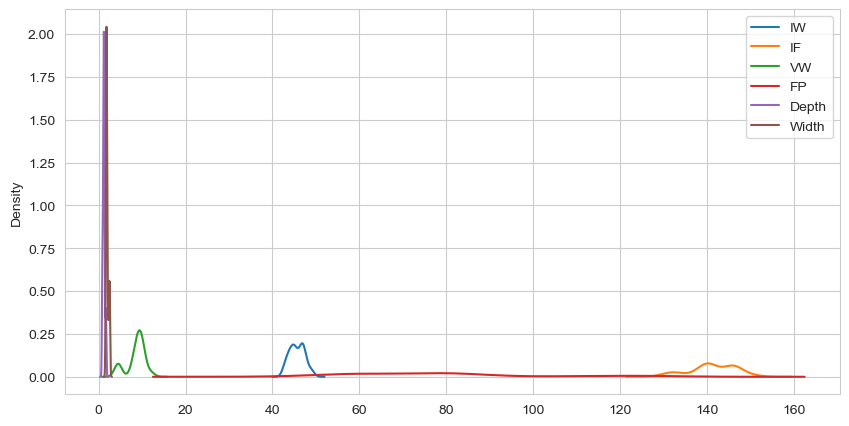

In [170]:
# Проверим датасет на выбросы.
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(kind='kde', ax=ax)

### Строим графики, чтобы наглядно посмотреть на разброс входных данных

<Figure size 1000x1000 with 0 Axes>

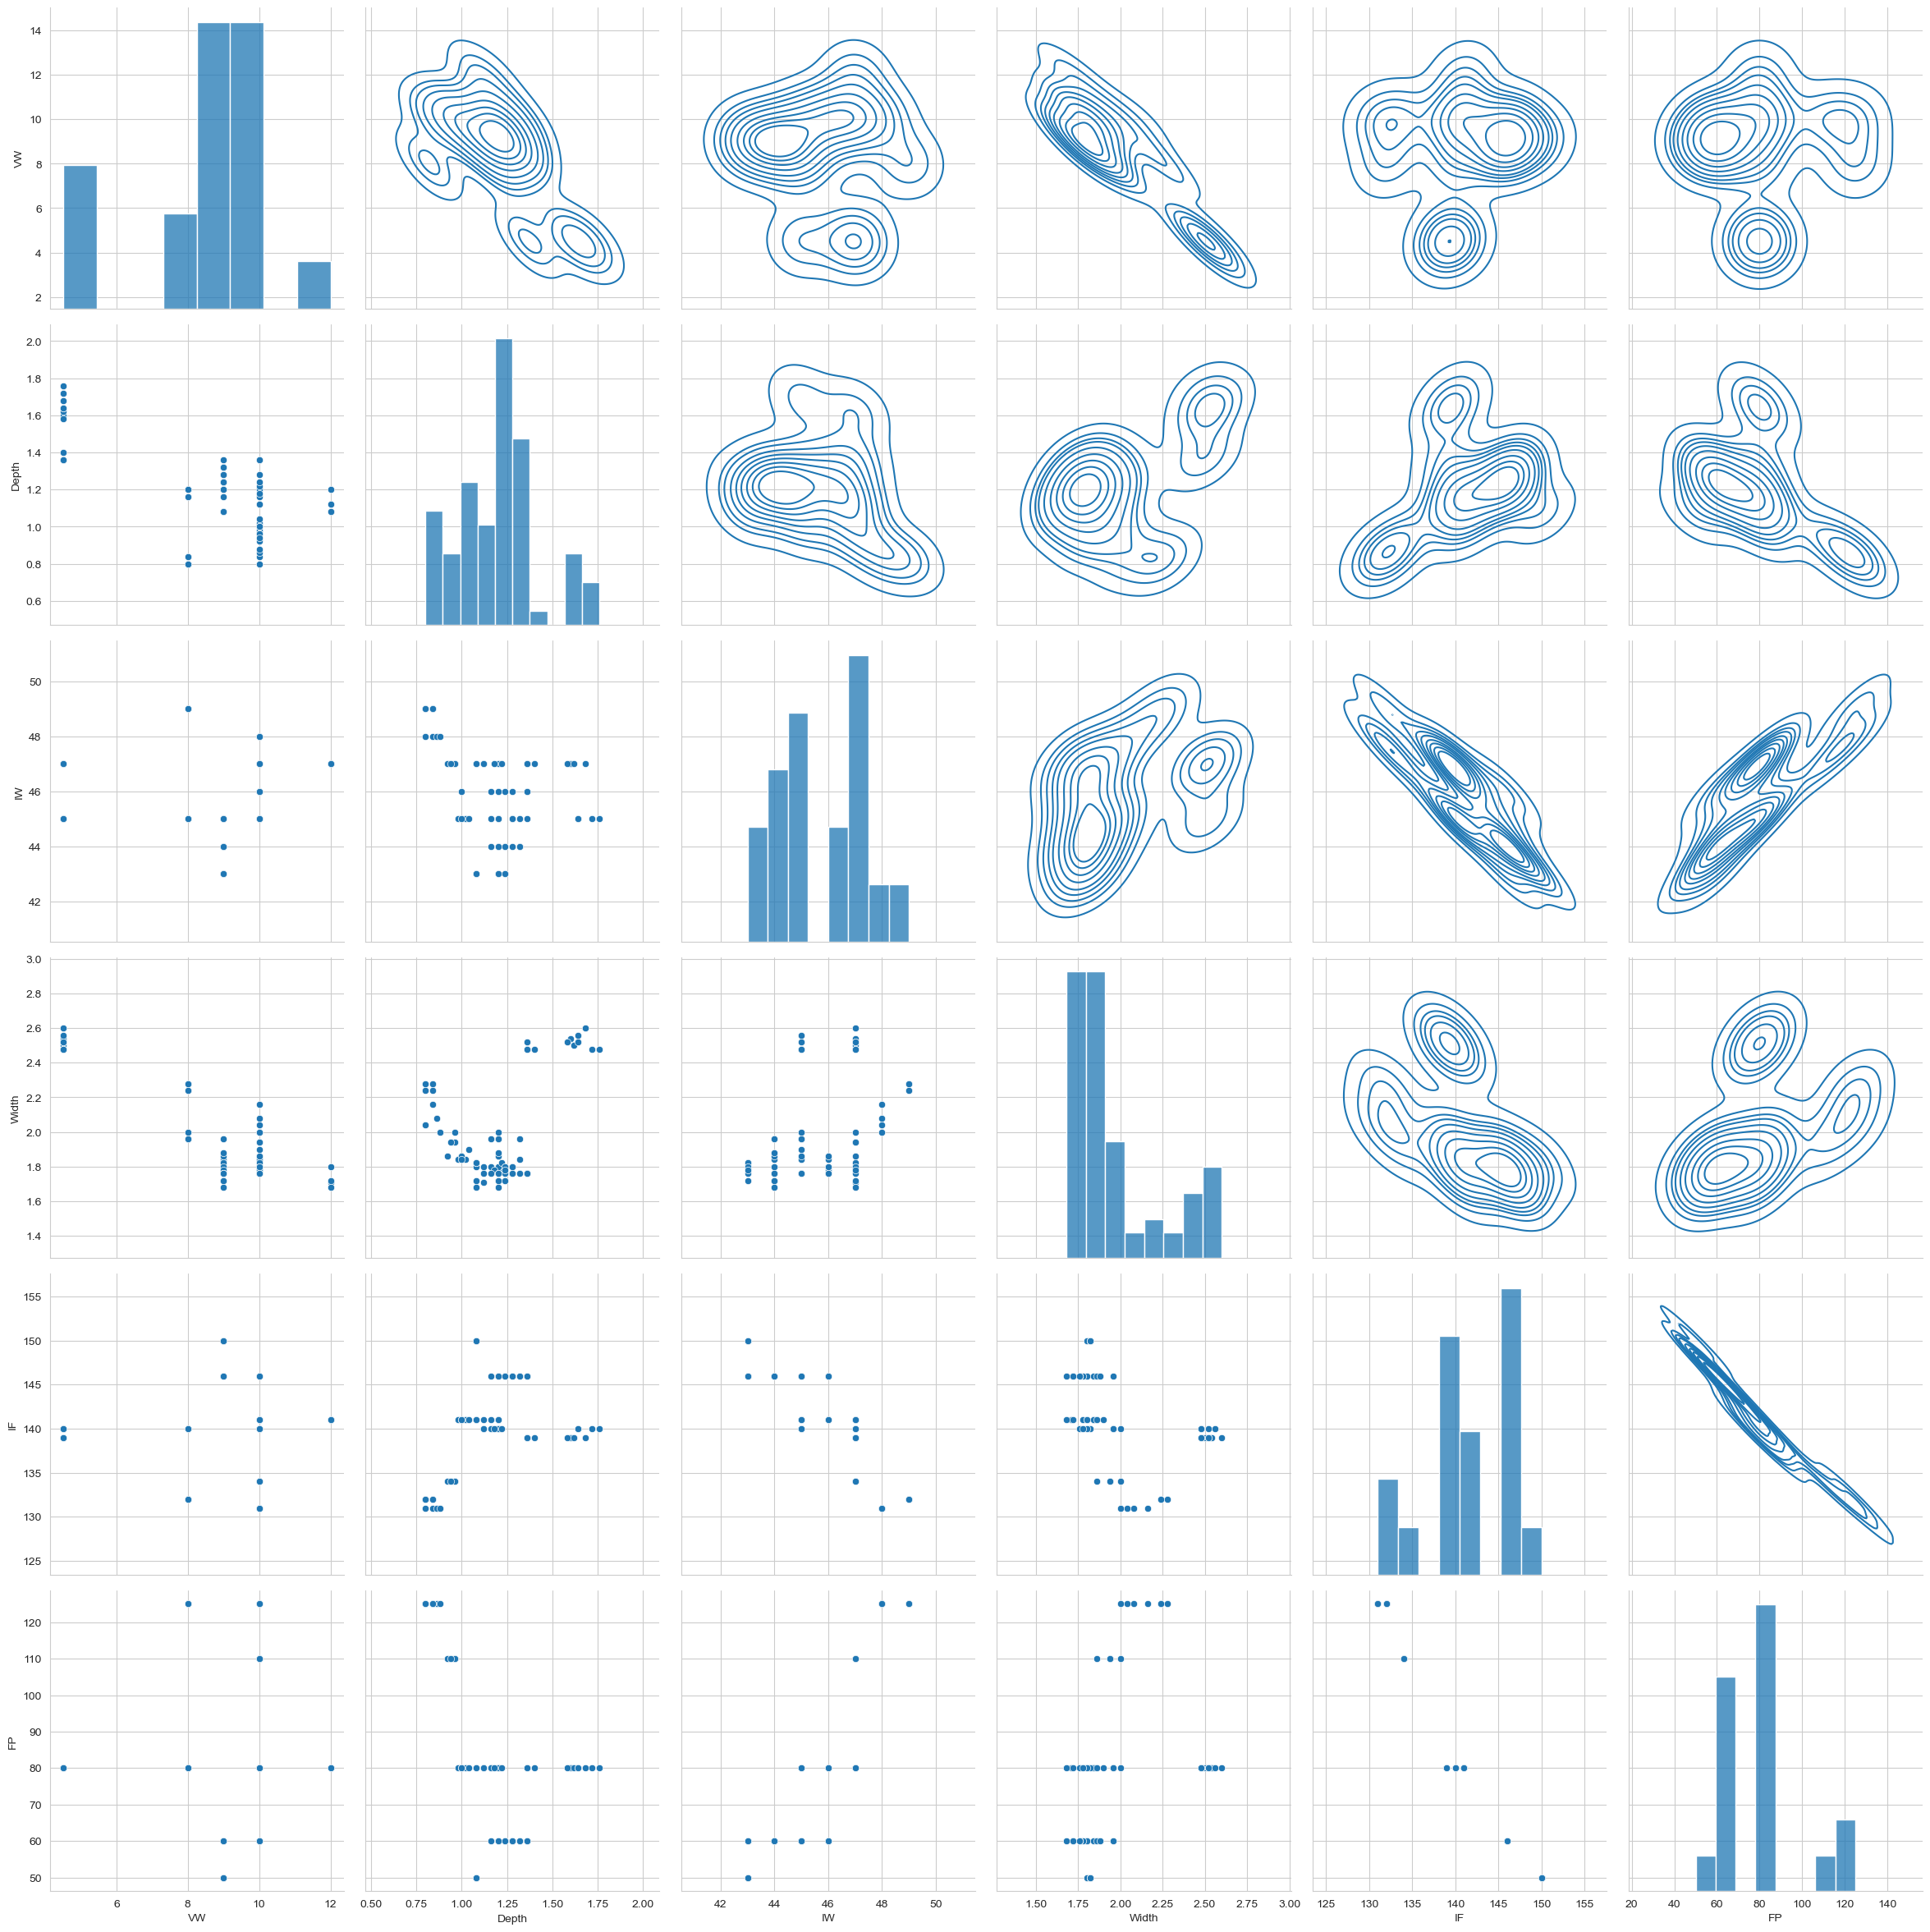

In [171]:
features = list(set(df.columns))
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
grids = sns.PairGrid(df[features], diag_sharey = False, height = 4)
grids.map_upper(sns.kdeplot)
grids.map_diag(sns.histplot, kde = False)
grids.map_lower(sns.scatterplot)

Согласно этому графику, мы уже можем сделать вывод, что каждый входной признак по-разному влияет на наши выходные параметры. Увеличение сварочного тока ('IW') приводит к снижению глубины шва ('Depth'), а снижение сварочного тока ('IW') приводит к уменьшению ширины шва ('Width').

## Визуализация выбросов с помощью прямоугольного графика

<Axes: xlabel='Depth'>

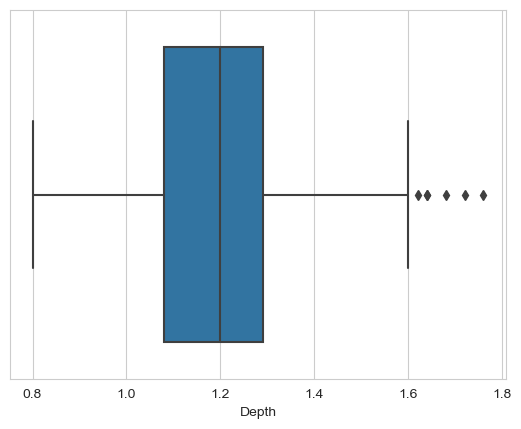

In [172]:
sns.boxplot(x=df["Depth"])

<Axes: xlabel='Width'>

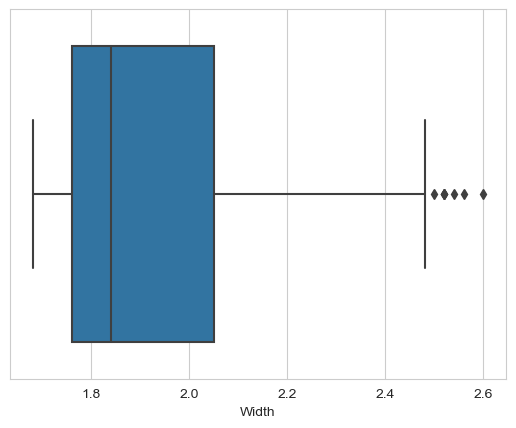

In [173]:
sns.boxplot(x=df["Width"])

Видим, что наибольшее количество выбросов в столбцах Width и Depth.

## Обработка/очистка выброса

Before Shape: (72, 6)
Before Shape: (72, 6)
After Shape: (1, 6)
After Shape: (59, 6)


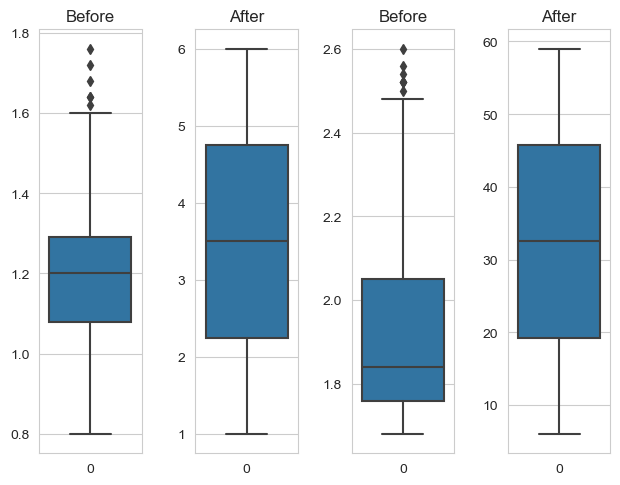

In [174]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(1,4)
plt.tight_layout()
## DataFrame
df = pd.read_csv("Downloads/ebw_data.csv", sep=';')
print("Before Shape:",df.shape)
print("Before Shape:",df.shape)
## Max and Min Quantile
max_val = df.Depth.quantile(0.95)
min_val = df.Depth.quantile(0.05)
max_val = df.Width.quantile(0.95)
min_val = df.Width.quantile(0.05)
## Removing all the outliers
df2 = df[(df['Depth']>min_val) & (df['Depth']<max_val)]
df3 = df[(df['Width']>min_val) & (df['Width']<max_val)]
## Visulization
print("After Shape:",df2.shape)
print("After Shape:",df3.shape)
sns.boxplot(df['Depth'],orient='v',ax=axes[0])
axes[0].title.set_text("Before")
sns.boxplot(df['Width'],orient='v',ax=axes[2])
axes[2].title.set_text("Before")
sns.boxplot(df2.shape,orient='v',ax=axes[1])
axes[1].title.set_text("After")
sns.boxplot(df3.shape,orient='v',ax=axes[3])
axes[3].title.set_text("After")
plt.show()


## Тепловая карта 

<Axes: >

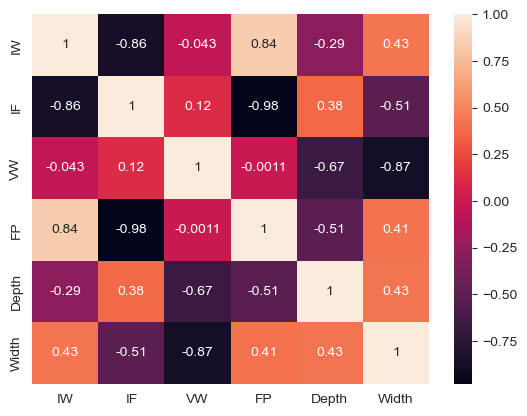

In [175]:
sns.heatmap(df.corr(), annot=True)

In [176]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [177]:
# Вычисляем коэффициенты ранговой корреляции Кендалла.
df.corr(method = 'kendall')

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.752857,0.135640,0.783660,-0.201166,0.316100
IF,-0.752857,1.000000,0.072083,-0.912174,0.201041,-0.506440
VW,0.135640,0.072083,1.000000,0.061463,-0.417191,-0.438444
FP,0.783660,-0.912174,0.061463,1.000000,-0.339637,0.443478
Depth,-0.201166,0.201041,-0.417191,-0.339637,1.000000,-0.003326
Width,0.316100,-0.506440,-0.438444,0.443478,-0.003326,1.000000


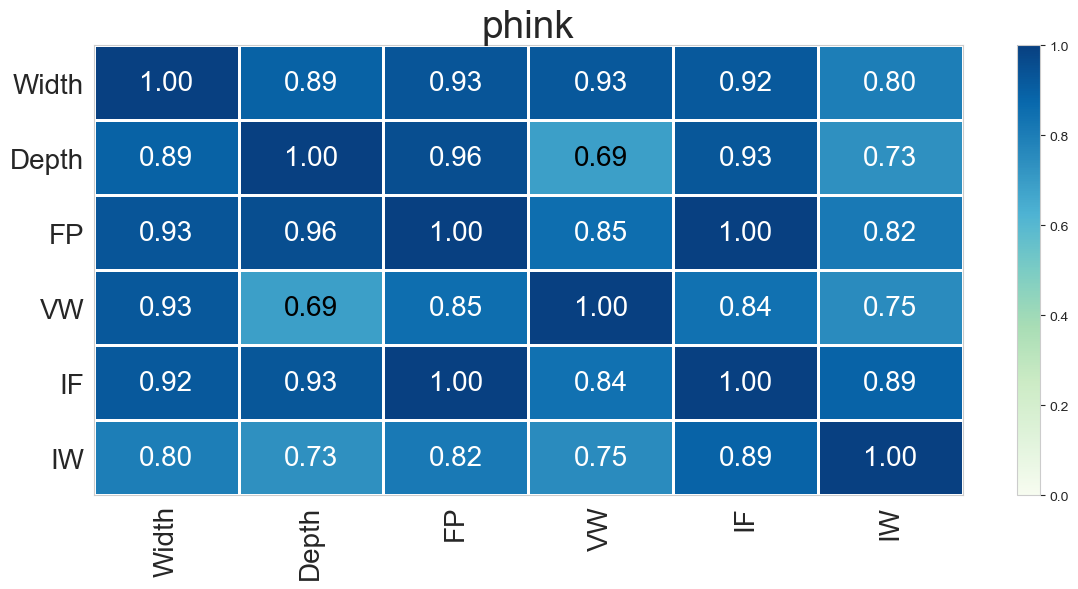

In [178]:
korel = df.phik_matrix(interval_cols=[])
plot_correlation_matrix(korel.values, 
                        x_labels = korel.columns, 
                        y_labels = korel.index, 
                        vmin = 0, vmax = 1, color_map = 'GnBu', 
                        title = 'phink', 
                        fontsize_factor = 2, 
                        figsize = (12, 6))
plt.tight_layout(h_pad = 28)

В некоторых столбцах можем видеть мощную взаимосвязь параметров. Это нам поможет удачно решить поставленную задачу. 

<Axes: xlabel='FP'>

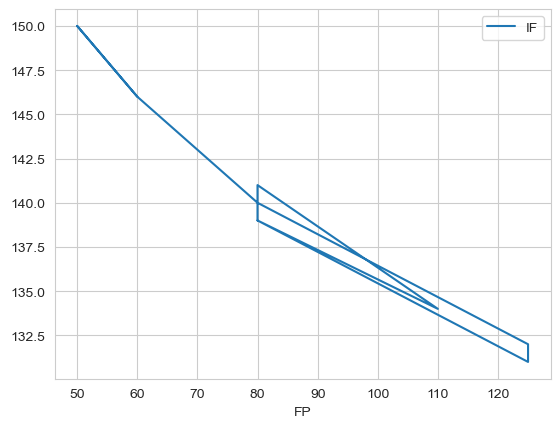

In [179]:
df.plot(x = "FP", y = "IF")
# Корреляция между параметрами равна -0.98, что и видно на этом графике

<Axes: xlabel='FP'>

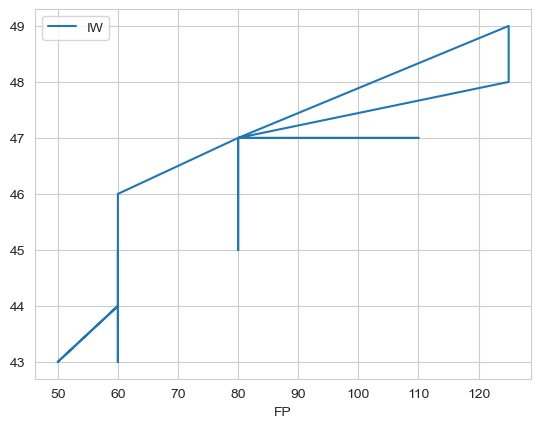

In [180]:
df.plot(x = "FP", y = "IW")
# Корреляция положительная и высокая, но график зависимости не донозначный, на мой взгляд

<Axes: xlabel='VW'>

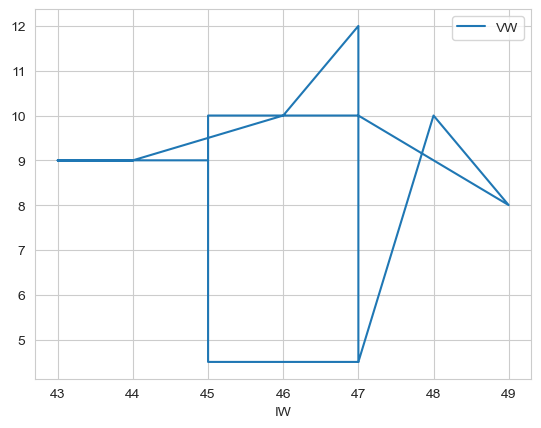

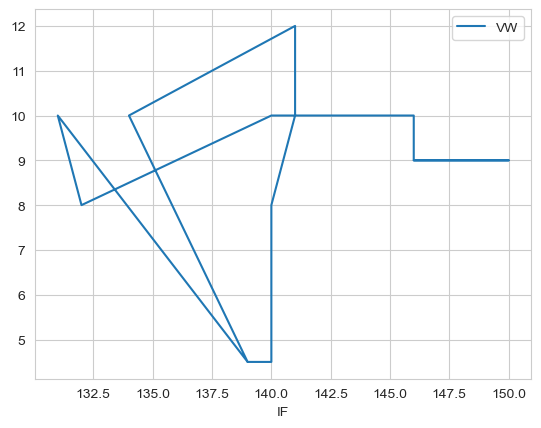

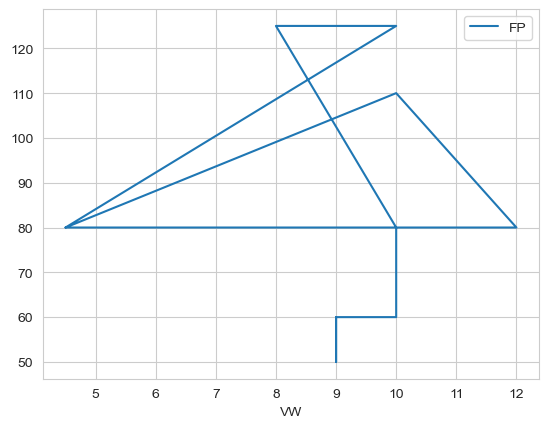

In [181]:
# На остальных трех графиках мы, кроме хаоса и беспорядка, никакой зависимости зрительной не наблюдаем. Оставлю их здесь для практики и наглядности
df.plot(x = "IW", y = "VW")
df.plot(x = "IF", y = "VW")
df.plot(x = "VW", y = "FP")

In [182]:
# количество уникальных значений по каждому параметру
df.nunique()
# Не так и много уникальных значений

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

К сожалению, есть повторяющие строки, но набор данных слишком мал и дальнейшая работа показала, что самое наилучшее предсказание дается на исходном датасете, без внесения каких-либо изменений (удаления дубликатов или добавления данных различными путями(кроме новых достоверных замеров), работы с выбросами или любыми другими манипуляциям данными.

# Предобработка

In [183]:
X = df.drop(["Width", "Depth"], axis=1)
Y = df[["Width", "Depth"]].copy()

In [184]:
X.describe()

,IW,IF,VW,FP
count,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333
std,1.678363,5.145763,2.061078,21.493530
min,43.000000,131.000000,4.500000,50.000000
25%,44.000000,139.000000,8.000000,60.000000
50%,45.500000,141.000000,9.000000,80.000000
75%,47.000000,146.000000,10.000000,80.000000
max,49.000000,150.000000,12.000000,125.000000


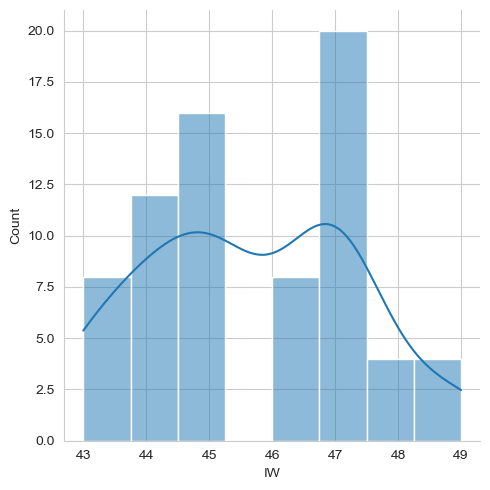

In [185]:
sns.displot(X.IW, kde=True)

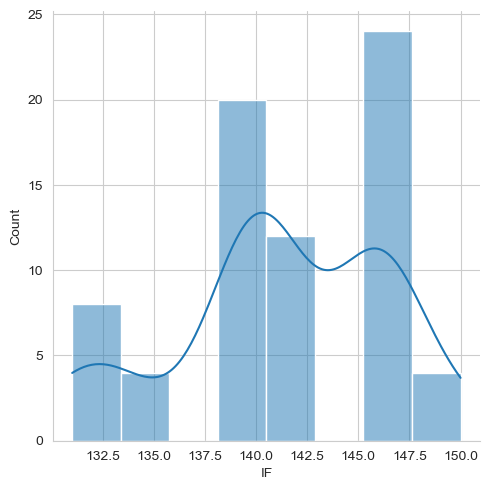

In [186]:
sns.displot(X.IF, kde=True)

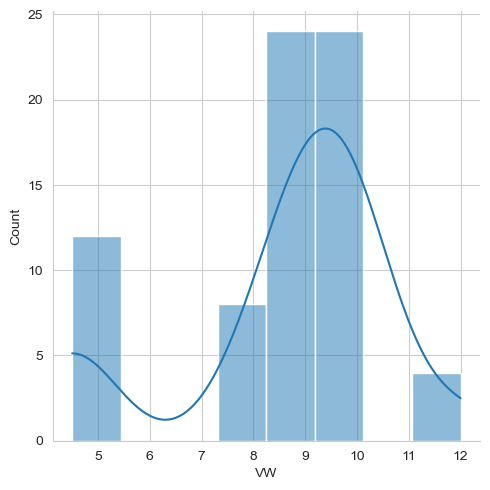

In [187]:
sns.displot(X.VW, kde=True)

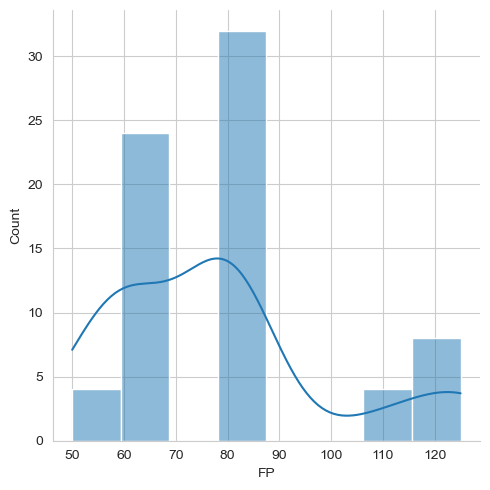

In [188]:
sns.displot(X.FP, kde=True)

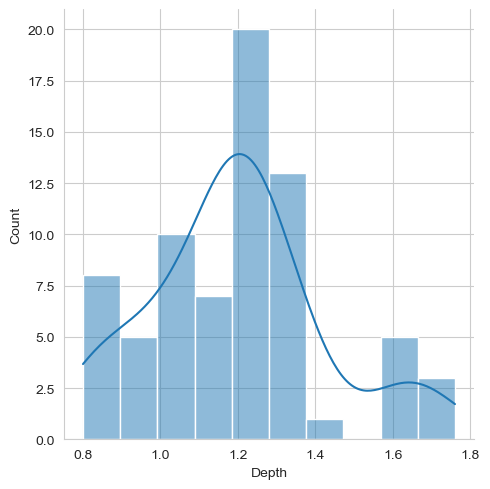

In [189]:
sns.displot(Y.Depth, kde=True)

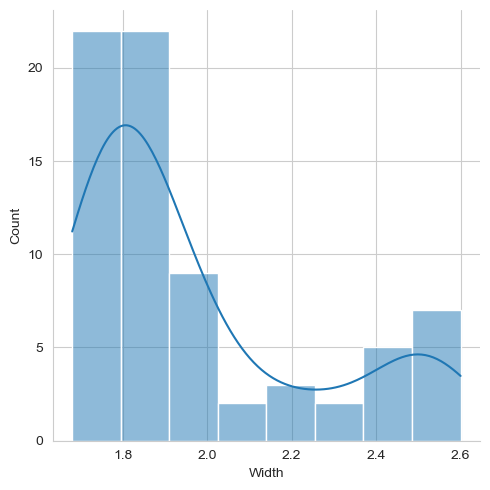

In [190]:
sns.displot(Y.Width, kde=True)

In [191]:
df.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

В итоге никакая дополнительная предобработка данных (кроме нормализации и стандартизации, возможно(?)) нам не треуется больше и можем приступать сразу к нормализации и стандартизации данных, а так же к обучению алгоритмов машинного обучения. Эти пункты я хочу выделить в отдельные разделы, как следующие этапы работы над набором данных. 

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    train_size=0.9, 
                                                    test_size=0.1, 
                                                    random_state=0, 
                                                    shuffle=True)

In [193]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [194]:
Y = Y.to_numpy()

In [195]:
X_train.shape, Y_train.shape

((64, 4), (64, 2))

# Разработка и обучение нескольких моделей алгоритмов машинного обучения

In [196]:
model = MultiOutputRegressor(tree.DecisionTreeRegressor())

# Обучение модели

In [197]:
model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

# Оценка модели

In [198]:
mean_absolute_error(Y_test, model.predict(X_test), multioutput='raw_values')

array([0.07041667, 0.06551587])

In [199]:
Y_test.mean(axis=0)

Width    2.0200
Depth    1.2375
dtype: float64

### В итоге предсказания по ширине и длине сварного шва получились близкими к идеалиным.

In [200]:
 model = tf.keras.Sequential([
     tf.keras.layers.Dense(units=4, input_dim=4, activation='relu'),
     tf.keras.layers.Dense(units=2, activation='relu')
 ])

In [201]:
 model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [202]:
 model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
     loss = 'mae',
 )

In [203]:
# Обучение модели

In [204]:
model.fit(X_train, Y_train)

2/2 [==============================] - 0s 2ms/step - loss: 1.3166


In [205]:
 history = model.fit(
     x=X_train, 
     y=Y_train,
     validation_data=(X_test, Y_test),
     epochs=50,
     verbose=1
 )

Epoch 1/50
2/2 [==============================] - 0s 88ms/step - loss: 1.0548 - val_loss: 0.8904
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.8450 - val_loss: 0.8689
Epoch 3/50
2/2 [==============================] - 0s 20ms/step - loss: 0.8889 - val_loss: 0.9298
Epoch 4/50
2/2 [==============================] - 0s 21ms/step - loss: 0.9189 - val_loss: 0.9067
Epoch 5/50
2/2 [==============================] - 0s 20ms/step - loss: 0.8713 - val_loss: 0.8172
Epoch 6/50
2/2 [==============================] - 0s 20ms/step - loss: 0.7715 - val_loss: 0.7876
Epoch 7/50
2/2 [==============================] - 0s 20ms/step - loss: 0.7491 - val_loss: 0.8445
Epoch 8/50
2/2 [==============================] - 0s 20ms/step - loss: 0.7805 - val_loss: 0.8309
Epoch 9/50
2/2 [==============================] - 0s 19ms/step - loss: 0.7522 - val_loss: 0.7806
Epoch 10/50
2/2 [==============================] - 0s 20ms/step - loss: 0.7140 - val_loss: 0.7792
Epoch 11/50
2/2 [============

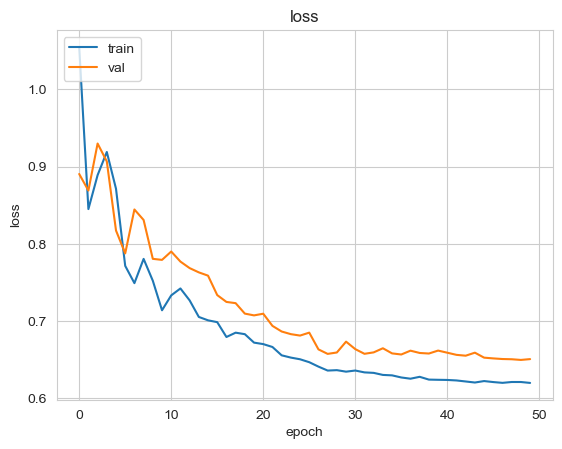

In [206]:
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'val'], loc='upper left')
 plt.show()

## Оценка модели

In [207]:
mean_absolute_error(Y_test, model.predict(X_test), multioutput='raw_values')

1/1 [==============================] - 0s 34ms/step


array([0.06417557, 1.2375    ])

In [208]:
Y_test.mean(axis=0)

Width    2.0200
Depth    1.2375
dtype: float64

### В итоге предсказания по ширине и длине сварного шва получились близкими к идеалиным.

### Сохранение моделей

In [209]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [210]:
model_loaded = keras.models.load_model("model")